# What makes a romance work?

A survey of 3510 individuals conducted by Stanford University in 2017 sought to determine the modern methods by which couples meet and stay together. The survey asks questions about the demographic information of the respondents as well as how they met their current partner. Link to source: https://data.stanford.edu/hcmst

## Previous Findings
Michael Rosenfeld, research director, concluded based on the findings that unpartnered heterosexual individuals are more comfortable being single long-term, as 80% of the group reported going on zero dates in the last 12 months. Gay men were also much more likely to use dating apps to meet partners: 18.4% of gay men had met a sexual partner through dating apps in the last year, while only 1.4% of heterosexual men and 1.3% of heterosexual women had done so. General sexual activity statistics were similarly lopsided: among heterosexual and gay men, 18% and 44% had met someone for dating, romance, or sex, respectively, while among heterosexual and lesbian women, 11% and 16% had met someone. The author concludes that phone app usage among the LGBT group may be higher due to the thin dating market, in which "potential partners are difficult to identify in face-to-face situations" as compared to heterosexuals (Rosenfeld, 20). Source: https://web.stanford.edu/~mrosenfe/Rosenfeld_Tinder_and_dating_apps.pdf

## Objectives
This project will further explore demographic intersections with partnerships, while narrowing its scope to how patterns in survey answers relate to the respondents' marriages and partnerships. Using binary marriage status of the respondents as the target, various algorithms will be tested to optimize classification of married and unmarried respondents. 

As the penalty for misclassification is equal in this case study for Type I and II errors, the F1 score will be used to gauge model accuracy, and the model with the optimal F1 score will be implemented upon the test set.  


In [1]:
#Import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from collections import defaultdict
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification


sns.set_style('darkgrid')

In [2]:
#Convert STATA files to readable CSV
data = pd.io.stata.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')
data.to_csv('Couples.csv')
couples= pd.read_csv('Couples.csv')
couples.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (48,103) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


In [3]:
#Inspect raw data
print(couples.shape)
couples.describe()

(3510, 286)


,Unnamed: 0,CaseID,CASEID_NEW,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,age_when_met,time_from_met_to_rel,year_fraction_first_cohab,time_from_rel_to_cohab,hcm2017_q24_length,hcm2017q24_summary_all_codes,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
count,3510.00000,3510.000000,3.510000e+03,2994.000000,2994.000000,551.000000,3110.000000,3110.000000,3510.000000,3510.000000,...,3341.000000,3263.000000,2630.000000,2578.000000,3394.000000,3295.000000,3323.000000,3378.000000,3383.000000,3510.000000
mean,1754.50000,2121.318803,2.181073e+06,0.999999,78337.460588,1.000003,1.000001,78337.599357,1.000000,69410.133903,...,26.651003,1.597072,1995.073197,1.900667,182.912493,1.978756,12.138730,12.279751,14.033255,13.945869
std,1013.39405,1241.582562,6.401295e+05,0.285004,22326.515502,0.908374,0.289889,22709.197606,0.437515,30367.960540,...,11.831718,4.361366,16.026444,2.727197,237.105284,1.118986,3.309426,3.229575,2.544954,2.546054
min,0.00000,2.000000,5.300100e+04,0.264700,20736.000000,0.190300,0.263200,20618.000000,0.058970,4093.000000,...,0.000000,0.000000,1944.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,877.25000,1040.250000,1.825512e+06,0.808000,63297.000000,0.519650,0.805000,63062.000000,0.818612,56819.750000,...,18.000000,0.000000,1983.208400,0.333374,54.000000,1.000000,12.000000,12.000000,12.000000,12.000000
50%,1754.50000,2118.500000,2.282692e+06,0.943900,73943.000000,0.713300,0.946750,74166.000000,1.012706,70292.000000,...,23.000000,0.166748,1997.416700,1.000000,124.000000,2.000000,12.000000,12.000000,13.000000,13.000000
75%,2631.75000,3189.750000,2.759544e+06,1.142650,89512.250000,1.134700,1.145200,89712.250000,1.245076,86421.000000,...,32.000000,1.083252,2009.291600,2.416626,222.750000,3.000000,13.000000,14.000000,16.000000,16.000000
max,3509.00000,4311.000000,2.972135e+06,2.671000,209239.000000,7.797400,2.751100,215514.000000,3.110826,215923.000000,...,84.000000,54.750000,2017.541600,36.750000,3855.000000,7.000000,20.000000,20.000000,20.000000,20.000000


In [4]:
#Check the first column for index duplicates
all(couples.iloc[:, 0]==couples.index)

True

In [5]:
#Drop ID columns
couples=couples.drop(['Unnamed: 0', 'CaseID', 'CASEID_NEW'], axis=1)

In [6]:
couples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510 entries, 0 to 3509
Columns: 283 entries, qflag to subject_yrsed
dtypes: float64(40), int64(9), object(234)
memory usage: 7.6+ MB


In [7]:
#Isolate columns with >60% nulls
null_counts= couples.isnull().sum().sort_values(ascending=False)
high_nulls= null_counts[null_counts>2106]
high_nulls

Q16_2_Codes            3503
Q3_Refused             3501
w6_how_meet_Refused    3498
Q16_Refused            3490
w6_how_many_app_2      3470
                       ... 
weight2                2959
w6_q5                  2901
S3                     2862
Q17B                   2733
w6_q20                 2507
Length: 78, dtype: int64

In [8]:
#Drop high null columns
couples= couples.drop(high_nulls.index, axis=1)

In [9]:
#Inspect remaining
couples.isnull().sum().sort_values(ascending=False)

Q17D       2096
S2         2085
Q17C       2068
Q26        1913
w6_q26     1711
           ... 
PPT25         0
PPT612        0
PPT1317       0
PPT18OV       0
qflag         0
Length: 205, dtype: int64

In [10]:
couples.ppagecat.unique()

array(['25-34', '55-64', '45-54', '65-74', '18-24', '35-44', '75+'],
      dtype=object)

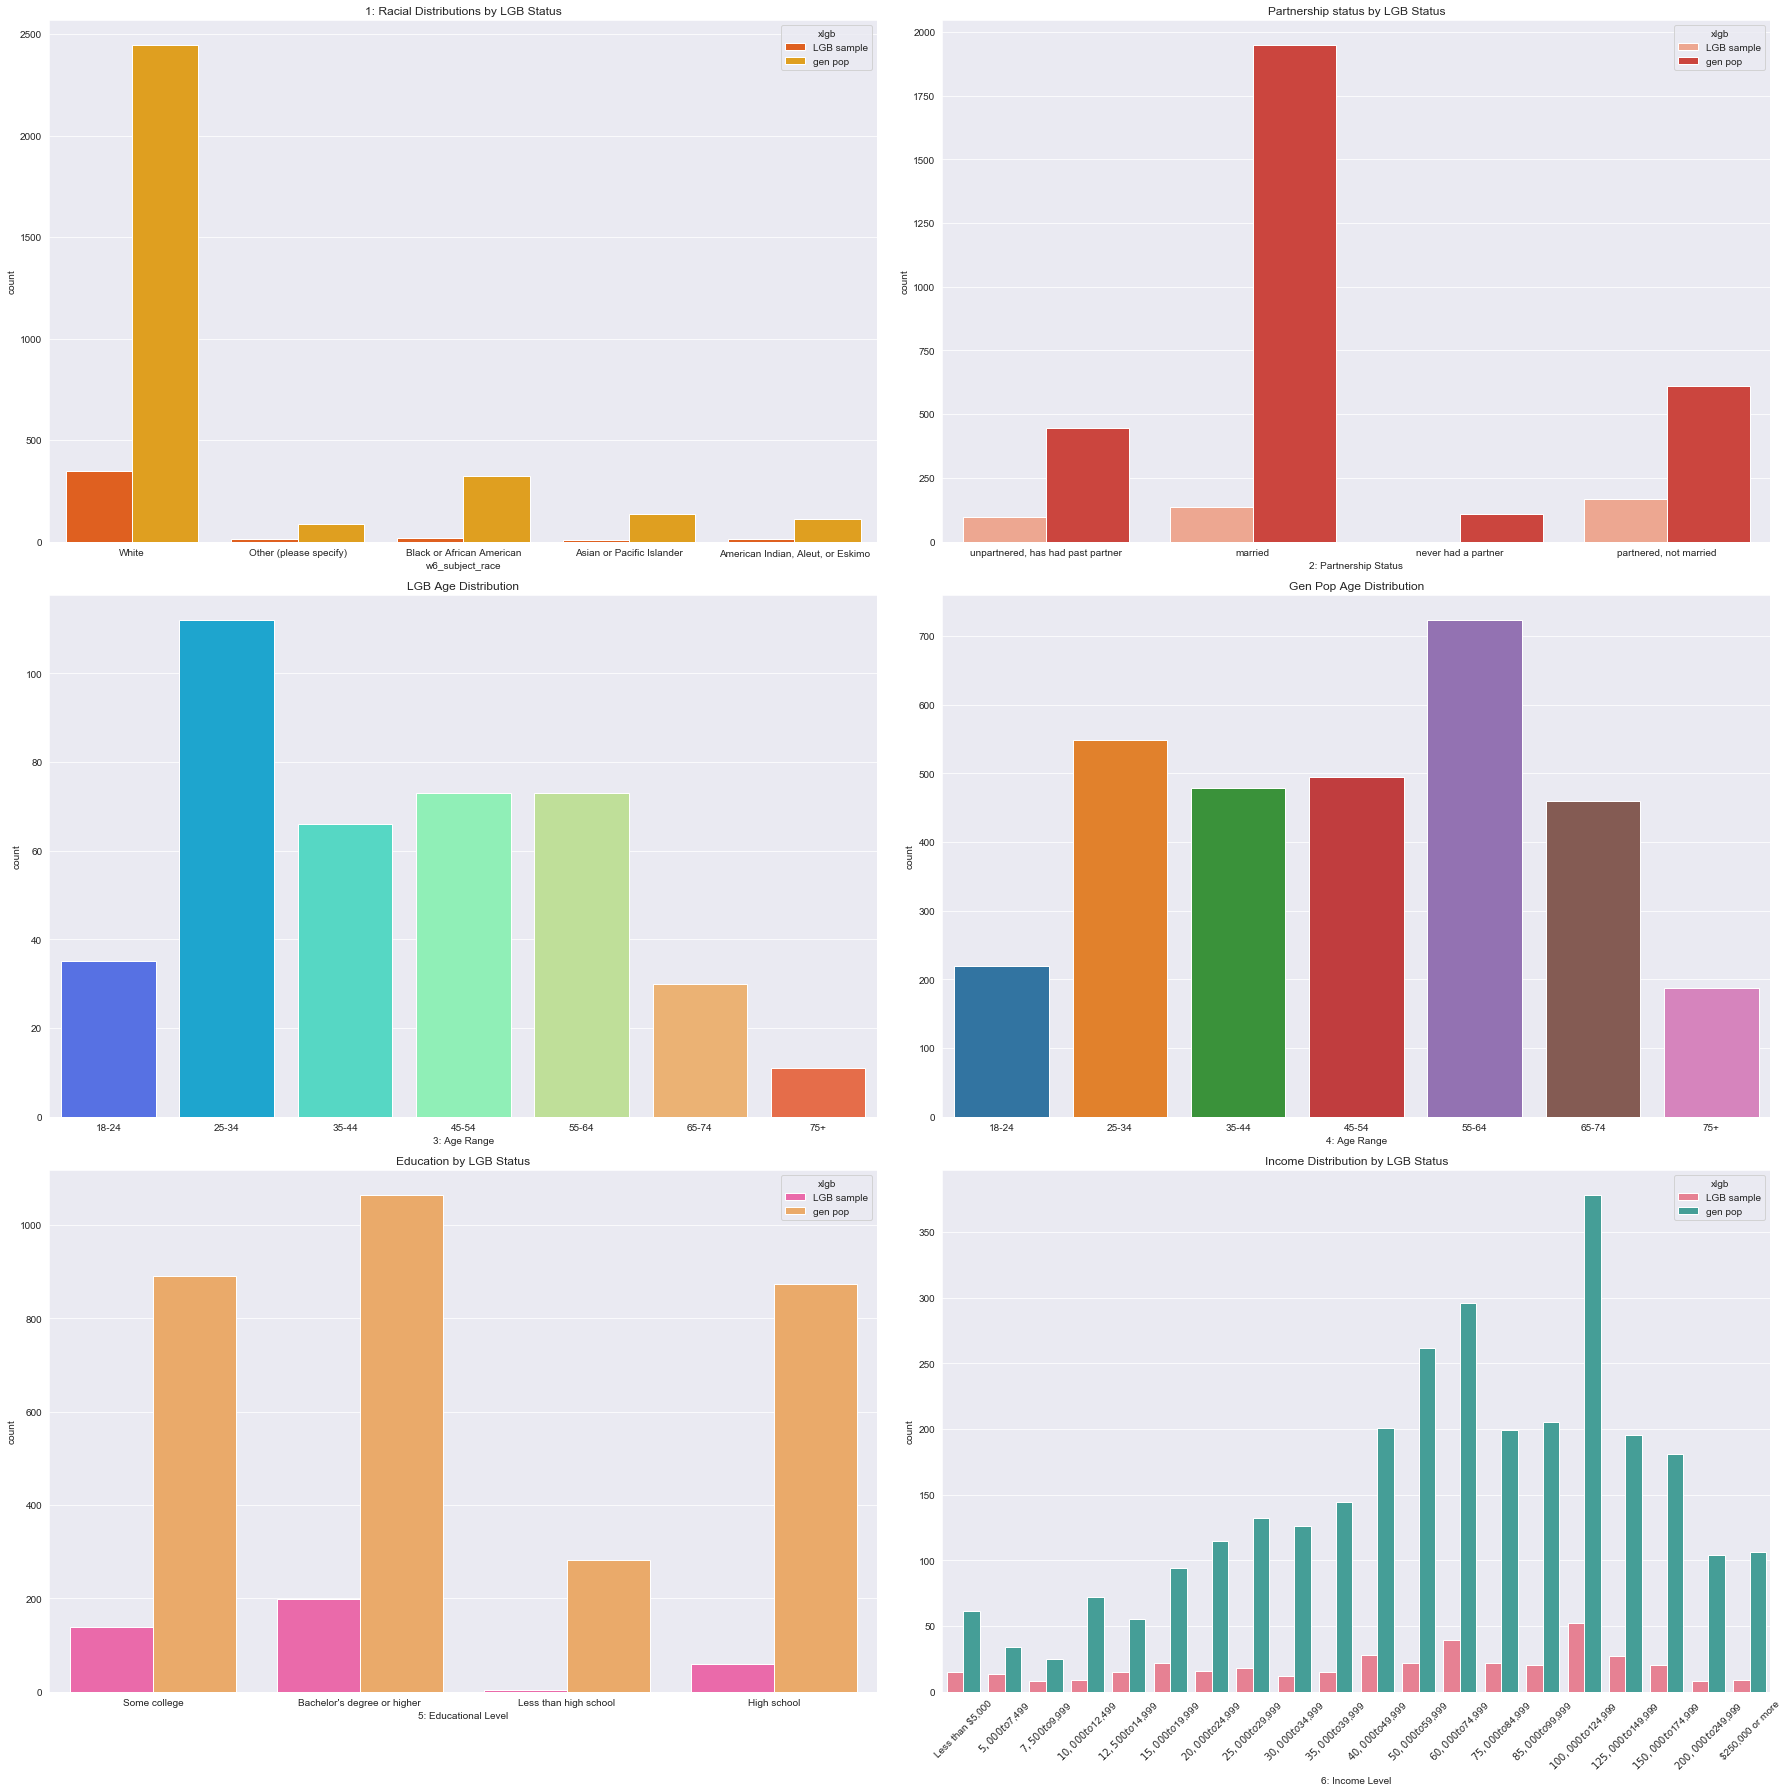

In [11]:
#Explore LGBT sample 
hetero= couples[couples.xlgb=='gen pop']
lgb= couples[couples.xlgb=='LGB sample']

plt.figure(figsize=(25, 25))

plt.subplot(3, 2, 1)
sns.countplot(x=couples.w6_subject_race, hue=couples.xlgb, palette='autumn')
plt.title('1: Racial Distributions by LGB Status')

plt.subplot(3, 2, 2)
sns.countplot(x=couples.partnership_status, hue=couples.xlgb, palette='Reds')
plt.xlabel('2: Partnership Status')
plt.title('Partnership status by LGB Status')

plt.subplot(3, 2, 3)
sns.countplot(lgb.ppagecat, order= ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+'], palette='rainbow')
plt.xlabel('3: Age Range')
plt.title('LGB Age Distribution')

plt.subplot(3, 2, 4)
sns.countplot(hetero.ppagecat, order= ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+'])
plt.xlabel('4: Age Range')
plt.title('Gen Pop Age Distribution')

plt.subplot(3, 2, 5)
sns.countplot(couples.ppeducat, hue=couples.xlgb, palette='spring')
plt.xlabel('5: Educational Level')
plt.title('Education by LGB Status')

plt.subplot(3, 2, 6)
sns.countplot(x=couples.ppincimp, hue=couples.xlgb, palette='husl', order=['Less than $5,000',
               '$5,000 to $7,499', '$7,500 to $9,999', '$10,000 to $12,499', '$12,500 to $14,999', 
                '$15,000 to $19,999', '$20,000 to $24,999','$25,000 to $29,999', '$30,000 to $34,999', 
                 '$35,000 to $39,999', '$40,000 to $49,999', '$50,000 to $59,999', '$60,000 to $74,999',
            '$75,000 to $84,999', '$85,000 to $99,999', '$100,000 to $124,999','$125,000 to $149,999',
            '$150,000 to $174,999', '$200,000 to $249,999','$250,000 or more'])
plt.xticks(rotation=45)
plt.xlabel('6: Income Level')
plt.title('Income Distribution by LGB Status')
plt.tight_layout()
plt.show()

## Insights

Figure 1: A majority of respondents are white regardless of orientation. 

Figure 2: A majority of the general population is married, while the LGB sample is evenly scattered betweem married, partnered, and single. There were no LGB respondents that reported never having a partner.

Figures 3&4: Side by side comparision of age distributions- many more LGB respondents were concentrated in younger ages. This may be a contributing factor to the disparity of meeting through phone apps between groups, as well as marriage rates, as younger populations   

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

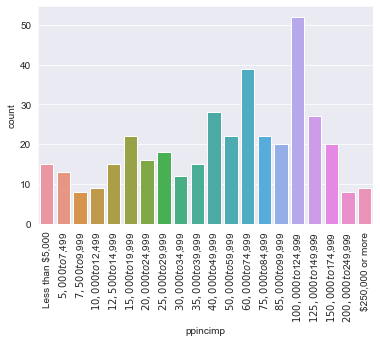

In [12]:
sns.countplot(lgb.ppincimp, order=['Less than $5,000',
               '$5,000 to $7,499', '$7,500 to $9,999', '$10,000 to $12,499', '$12,500 to $14,999', 
                '$15,000 to $19,999', '$20,000 to $24,999','$25,000 to $29,999', '$30,000 to $34,999', 
                 '$35,000 to $39,999', '$40,000 to $49,999', '$50,000 to $59,999', '$60,000 to $74,999',
            '$75,000 to $84,999', '$85,000 to $99,999', '$100,000 to $124,999','$125,000 to $149,999',
            '$150,000 to $174,999', '$200,000 to $249,999','$250,000 or more'] )
plt.xticks(rotation='vertical')

In [13]:
couples.ppincimp.unique()

array(['$40,000 to $49,999', '$150,000 to $174,999',
       '$200,000 to $249,999', '$175,000 to $199,999',
       '$75,000 to $84,999', '$50,000 to $59,999', '$60,000 to $74,999',
       '$125,000 to $149,999', '$15,000 to $19,999', '$250,000 or more',
       '$85,000 to $99,999', '$100,000 to $124,999', '$20,000 to $24,999',
       '$30,000 to $34,999', '$10,000 to $12,499', '$25,000 to $29,999',
       '$5,000 to $7,499', '$7,500 to $9,999', '$35,000 to $39,999',
       'Less than $5,000', '$12,500 to $14,999'], dtype=object)

In [14]:
#Inspect categorical variables 
#List total categories per object variable
categorical = couples.select_dtypes(include=['object'])
for col in categorical:
    print(col)
    print(categorical[col].nunique())

qflag
2
speed_flag
2
consent
1
xlgb
2
S1
2
S2
3
Q4
4
Q6A
6
Q6B
6
Q9
79
Q10
15
Q11
15
Q12
8
Q14
15
Q15A7
3
Q17A
5
Q17C
6
Q17D
6
Q19
3
Q21A_Year
73
Q21A_Month
13
Q21B_Year
73
Q21B_Month
13
Q21C_Year
69
Q21C_Month
13
Q21D_Year
69
Q21D_Month
13
w6_identity
6
Q23
5
Q25
3
Q26
3
Q27
3
Q28
3
w6_friend_connect_1
2
w6_friend_connect_2
2
w6_friend_connect_3
2
w6_friend_connect_4
2
w6_friend_connect_Refused
2
Q32
8
Q34
6
w6_sex_frequency
6
w6_otherdate
3
partyid7
7
PERSNET_hom
4
ppc10017
4
ppc21310
8
ppp20071
4
ppp20072
7
ppagecat
7
ppagect4
4
ppeduc
14
ppeducat
4
ppethm
5
ppgender
2
pphhhead
2
pphouse
5
ppincimp
21
ppmarit
6
ppmsacat
2
PPREG4
4
ppreg9
9
pprent
3
ppwork
7
Race_1
3
Race_2
3
Race_3
3
Race_4
3
Race_5
3
Race_6
3
race1
3
race2
3
race3
3
race4
3
race5
3
race6
3
race7
3
race8
3
race9
3
race10
3
race11
3
race12
3
race13
3
race14
3
race15
3
w6_took_the_survey
3
w6_prior_identity_lgb
2
w6_same_sex_couple
2
w6_same_sex_couple_gender
3
w6_q4
4
w6_q6a
6
w6_q6b
6
w6_q10
15
w6_q11
15
w6_q12
8
w6

In [15]:
#Break down largest categories to maintain low dimensionality
#Find categorical columns with 15 categories or more
heavy_cats=[]
for i in categorical:
    column = categorical[i]
    if column.nunique()>=15:
        print(i)
        heavy_cats.append(i)

Q9
Q10
Q11
Q14
Q21A_Year
Q21B_Year
Q21C_Year
Q21D_Year
ppincimp
w6_q10
w6_q11
w6_q14


## Heavy Category Question codes

Q9: How old is your partner?

Q10: What is the highest level of schooling your partner has completed?

Q11: What is the highest level of schooling your partner's mother has completed?

Q14:  What is the highest level of schooling your mother has completed?

Q21A_Year: In what year did you first meet your partner?

Q21B_Year: In what year did your romantic relationship with your partner begin?

Q21C_Year: In what year did ou first live together? 

Q21D_Year: In what year did you marry your partner?

ppincimp: Household income

w6_q10: Recode of Q10

w6_q11: Recode of Q11

w6_q14: Recode of q14


In [16]:
#Inspect slice
couples[heavy_cats].head()

,Q9,Q10,Q11,Q14,Q21A_Year,Q21B_Year,Q21C_Year,Q21D_Year,ppincimp,w6_q10,w6_q11,w6_q14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$40,000 to $49,999",HS graduate or GED,HS graduate or GED,Associate degree
1,52.0,Masters degree,HS graduate or GED,Bachelors degree,1983,1995,1996,1996,"$150,000 to $174,999",Masters degree,HS graduate or GED,Bachelors degree
2,45.0,Associate degree,9th grade,7th or 8th grade,2006,2006,2006,2008,"$200,000 to $249,999",Associate degree,9th grade,7th or 8th grade
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$40,000 to $49,999",HS graduate or GED,Bachelors degree,HS graduate or GED
4,59.0,Bachelors degree,Associate degree,Masters degree,1983,1983,1984,1984,"$175,000 to $199,999",Bachelors degree,Associate degree,Masters degree


In [17]:
#Convert age variable
couples.Q9= pd.to_numeric(couples.Q9, errors='coerce')

In [18]:
#Transform education variables to ordinal 
educ_mapper= {'Bachelor\x92s degree':11, '7th or 8th grade':3,
       'Master\x92s degree':12, 'HS graduate or GED':8, 'Associate degree':10,
       '10th grade':5, '5th or 6th grade':2, 'Some college, no degree':9,
       '12th grade no diploma':7, '1st-4th grade':1, '11th grade':6,
       'Professional or Doctorate degree':13, '9th grade':4,
       'No formal education':0, 'Refused':0}

In [19]:
#Find education-related variables
educ_vars=[]
object_vars= couples.select_dtypes(include='object')
for col in object_vars:
    results= object_vars[col].str.contains('degree|grade', na=False).sum()
    if results>1:
        educ_vars.append(col)
        print(col, ': {} matches'.format(results))

Q10 : 2199 matches
Q11 : 1516 matches
Q14 : 1802 matches
ppeduc : 2571 matches
ppeducat : 1263 matches
w6_q10 : 2541 matches
w6_q11 : 1760 matches
w6_q14 : 2131 matches


In [20]:
#Encode and fill NaNs 
educ_vars2= pd.DataFrame([couples[col].replace(educ_mapper).fillna(8) for col in couples[educ_vars]]).T
educ_vars2.head()

,Q10,Q11,Q14,ppeduc,ppeducat,w6_q10,w6_q11,w6_q14
0,8,8,8,10,Some college,8,8,10
1,12,8,11,Masters degree,Bachelor's degree or higher,12,8,11
2,10,4,3,Masters degree,Bachelor's degree or higher,10,4,3
3,8,8,8,12th grade NO DIPLOMA,Less than high school,8,11,8
4,11,10,12,Bachelors degree,Bachelor's degree or higher,11,10,12


In [21]:
#Re-map remaining strings
educ_mapper2= {'Masters degree':12, '12th grade NO DIPLOMA':7, 'Bachelors degree':11,
       'HIGH SCHOOL GRADUATE - high school DIPLOMA or the equivalent (GED)':8,
               '1st, 2nd, 3rd, or 4th grade':1, 'Associate degree':10, '9th grade':4, 
              'Some college':9, 'High school': 8, 'Less than high school':3, 
              'Some college, no degree':9, 'Professional or Doctorate degree':13, 
              "Bachelor's degree or higher":11}

educ_vars2.iloc[:, 3:5]= pd.DataFrame([couples[col].replace(educ_mapper2).fillna(8) for col in educ_vars2.iloc[:, 3:5]]).T
educ_vars2.head()

,Q10,Q11,Q14,ppeduc,ppeducat,w6_q10,w6_q11,w6_q14
0,8,8,8,10,9,8,8,10
1,12,8,11,12,11,12,8,11
2,10,4,3,12,11,10,4,3
3,8,8,8,7,3,8,11,8
4,11,10,12,11,11,11,10,12


In [22]:
#Convert Year variables to integers
for col in couples[heavy_cats].loc[:, 'Q21A_Year':'Q21D_Year']:
    couples[col]= pd.to_numeric(couples[col], errors='coerce')

In [23]:
#Inspect unique household incomes
couples.ppincimp.unique()

array(['$40,000 to $49,999', '$150,000 to $174,999',
       '$200,000 to $249,999', '$175,000 to $199,999',
       '$75,000 to $84,999', '$50,000 to $59,999', '$60,000 to $74,999',
       '$125,000 to $149,999', '$15,000 to $19,999', '$250,000 or more',
       '$85,000 to $99,999', '$100,000 to $124,999', '$20,000 to $24,999',
       '$30,000 to $34,999', '$10,000 to $12,499', '$25,000 to $29,999',
       '$5,000 to $7,499', '$7,500 to $9,999', '$35,000 to $39,999',
       'Less than $5,000', '$12,500 to $14,999'], dtype=object)

In [24]:
#Create algorithm to parse income boundaries
def getIntValue(s):
    return int(''.join(s[1:].split(',')))

def parse_bounds(s):
    if 'Less than ' in s:
            return [0, 5000]
    elif ' or more' in s:
            s = s.split(" or more")
            a = getIntValue(s[0])
            return [a, a+50000]  
    s=s.split(" to ") 
    return [getIntValue(s[0]), getIntValue(s[1])]

         
bounds_list=[]
for x in couples.ppincimp.unique():
    results= parse_bounds(x)
    bounds_list.append(results)

for x in bounds_list:
    print(x)

[40000, 49999]
[150000, 174999]
[200000, 249999]
[175000, 199999]
[75000, 84999]
[50000, 59999]
[60000, 74999]
[125000, 149999]
[15000, 19999]
[250000, 300000]
[85000, 99999]
[100000, 124999]
[20000, 24999]
[30000, 34999]
[10000, 12499]
[25000, 29999]
[5000, 7499]
[7500, 9999]
[35000, 39999]
[0, 5000]
[12500, 14999]


In [25]:
#Sort bounds_list by minimum left value
bounds_means= [(x[1]+x[0])/2 for x in bounds_list]

In [26]:
#Find mean of income range, then
#Create loop zipping in ppincimp keys to bounds_means values 
bounds_means= [(x[1]+x[0])/2 for x in bounds_list]
income_dict= dict(zip(couples.ppincimp.unique(), bounds_means))
income_dict

{'$40,000 to $49,999': 44999.5,
 '$150,000 to $174,999': 162499.5,
 '$200,000 to $249,999': 224999.5,
 '$175,000 to $199,999': 187499.5,
 '$75,000 to $84,999': 79999.5,
 '$50,000 to $59,999': 54999.5,
 '$60,000 to $74,999': 67499.5,
 '$125,000 to $149,999': 137499.5,
 '$15,000 to $19,999': 17499.5,
 '$250,000 or more': 275000.0,
 '$85,000 to $99,999': 92499.5,
 '$100,000 to $124,999': 112499.5,
 '$20,000 to $24,999': 22499.5,
 '$30,000 to $34,999': 32499.5,
 '$10,000 to $12,499': 11249.5,
 '$25,000 to $29,999': 27499.5,
 '$5,000 to $7,499': 6249.5,
 '$7,500 to $9,999': 8749.5,
 '$35,000 to $39,999': 37499.5,
 'Less than $5,000': 2500.0,
 '$12,500 to $14,999': 13749.5}

In [27]:
#Replace values with income_dict values
couples.ppincimp= couples.ppincimp.map(income_dict)
couples.ppincimp

0        44999.5
1       162499.5
2       224999.5
3        44999.5
4       187499.5
          ...   
3505     67499.5
3506    275000.0
3507    137499.5
3508     67499.5
3509     44999.5
Name: ppincimp, Length: 3510, dtype: float64

Text(0.5, 1.0, 'Married Counts by Income Level')

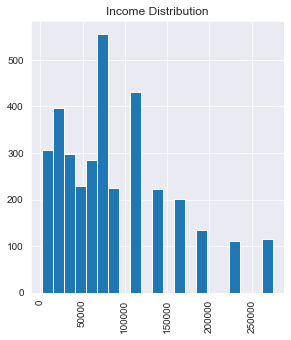

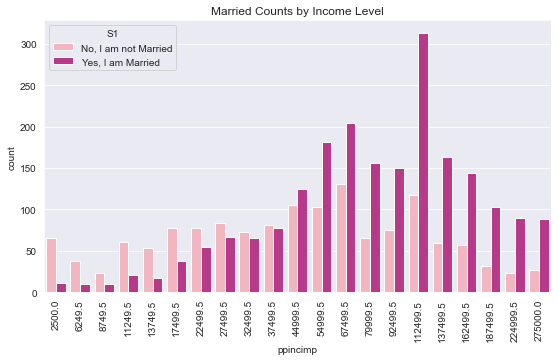

In [28]:
#Visualize marriage status per income category 
#Count income bins, groupby S1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(couples.ppincimp, bins=couples.ppincimp.nunique())
plt.xticks(rotation='vertical')
plt.title('Income Distribution')

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
sns.countplot(couples.ppincimp, hue=couples.S1, palette='RdPu')
plt.xticks(rotation='vertical')
plt.title('Married Counts by Income Level')

Figure 2 shows that there are many more unmarried people with low household incomes, and the count of unmarried people per income bracket exceeds the married population under 40,000 dollars. The household income of married individuals includes partner income, but the marriage bars are more than twice the height of the unmarried bars at income levels exceeding 100,000 dollars, indicating that married individuals are more wealthy on average than their single peers (which could explain why they were stronger candidates for marriage).

In [29]:
couples[heavy_cats].describe()

,Q9,Q21A_Year,Q21B_Year,Q21C_Year,Q21D_Year,ppincimp
count,2835.000000,2820.000000,2765.000000,2412.000000,2045.000000,3510.000000
mean,49.039153,1993.852482,1995.483906,1994.946517,1993.366259,86303.302137
std,16.110577,16.957123,16.657816,15.914226,16.314195,64763.907706
min,10.000000,1939.000000,1942.000000,1944.000000,1944.000000,2500.000000
25%,35.000000,1981.000000,1983.000000,1983.000000,1981.000000,37499.500000
50%,50.000000,1997.000000,1999.000000,1998.000000,1995.000000,67499.500000
75%,62.000000,2008.000000,2010.000000,2009.000000,2008.000000,112499.500000
max,95.000000,2017.000000,2017.000000,2017.000000,2017.000000,275000.000000


In [30]:
#Clean continuous variables
cont_vars= couples.select_dtypes(include=['float', 'int'])
cont_vars.describe()

,weight1,weight1_freqwt,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,duration,DOV_Branch,Q9,Q16,...,age_when_met,time_from_met_to_rel,year_fraction_first_cohab,time_from_rel_to_cohab,hcm2017_q24_length,hcm2017q24_summary_all_codes,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
count,2994.000000,2994.000000,3110.000000,3110.000000,3510.000000,3510.000000,3510.000000,3403.000000,2835.000000,2836.000000,...,3341.000000,3263.000000,2630.000000,2578.000000,3394.000000,3295.000000,3323.000000,3378.000000,3383.000000,3510.000000
mean,0.999999,78337.460588,1.000001,78337.599357,1.000000,69410.133903,267.449858,1.158977,49.039153,3.495416,...,26.651003,1.597072,1995.073197,1.900667,182.912493,1.978756,12.138730,12.279751,14.033255,13.945869
std,0.285004,22326.515502,0.289889,22709.197606,0.437515,30367.960540,1406.882283,0.365709,16.110577,5.095177,...,11.831718,4.361366,16.026444,2.727197,237.105284,1.118986,3.309426,3.229575,2.544954,2.546054
min,0.264700,20736.000000,0.263200,20618.000000,0.058970,4093.000000,0.000000,1.000000,10.000000,0.000000,...,0.000000,0.000000,1944.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.808000,63297.000000,0.805000,63062.000000,0.818612,56819.750000,8.000000,1.000000,35.000000,0.000000,...,18.000000,0.000000,1983.208400,0.333374,54.000000,1.000000,12.000000,12.000000,12.000000,12.000000
50%,0.943900,73943.000000,0.946750,74166.000000,1.012706,70292.000000,11.000000,1.000000,50.000000,2.000000,...,23.000000,0.166748,1997.416700,1.000000,124.000000,2.000000,12.000000,12.000000,13.000000,13.000000
75%,1.142650,89512.250000,1.145200,89712.250000,1.245076,86421.000000,19.000000,1.000000,62.000000,5.000000,...,32.000000,1.083252,2009.291600,2.416626,222.750000,3.000000,13.000000,14.000000,16.000000,16.000000
max,2.671000,209239.000000,2.751100,215514.000000,3.110826,215923.000000,22135.000000,2.000000,95.000000,50.000000,...,84.000000,54.750000,2017.541600,36.750000,3855.000000,7.000000,20.000000,20.000000,20.000000,20.000000


In [31]:
#Before winsorizing outliers, NaNs must be imputed
for col in cont_vars:
    cont_vars.loc[:, col]= cont_vars.loc[:, col].fillna(cont_vars.loc[:, col].median())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [32]:
#Winsorize outliers having >2stds from median        
for col in cont_vars:
    if cont_vars.loc[:, col].max()> cont_vars.loc[:, col].median() + 2*(cont_vars.loc[:, col].std()):
        cont_vars.loc[:, col]= winsorize(cont_vars.loc[:, col], (0, 0.10))
    elif cont_vars.loc[:, col].min()< cont_vars.loc[:, col].median() - 2*(cont_vars.loc[:, col].std()):
        cont_vars.loc[:, col]= winsorize(cont_vars.loc[:, col], (0.10, 0))
        
cont_vars.describe()

,weight1,weight1_freqwt,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,duration,DOV_Branch,Q9,Q16,...,age_when_met,time_from_met_to_rel,year_fraction_first_cohab,time_from_rel_to_cohab,hcm2017_q24_length,hcm2017q24_summary_all_codes,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
count,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,...,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000
mean,0.971051,76069.721652,0.972701,76198.966952,0.975034,67677.282906,17.698291,1.154131,48.670085,2.615385,...,25.547009,0.745537,1996.390252,1.331553,149.791453,1.870370,12.044160,12.156695,13.865954,13.817664
std,0.216206,16937.013267,0.224450,17582.934401,0.391264,27157.788004,16.824031,0.361126,13.495510,2.528423,...,9.400190,1.113796,12.390608,1.129856,113.311965,0.875235,3.072908,2.981171,2.256568,2.301715
min,0.264700,20736.000000,0.263200,20618.000000,0.058970,4093.000000,0.000000,1.000000,10.000000,0.000000,...,0.000000,0.000000,1974.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.829475,64978.750000,0.822300,64417.000000,0.818612,56819.750000,8.000000,1.000000,38.000000,0.000000,...,19.000000,0.000000,1988.125000,0.500000,56.000000,1.000000,12.000000,12.000000,12.000000,12.000000
50%,0.943900,73943.000000,0.946750,74166.000000,1.012706,70292.000000,11.000000,1.000000,50.000000,2.000000,...,23.000000,0.166748,1997.416700,1.000000,124.000000,2.000000,12.000000,12.000000,13.000000,13.000000
75%,1.102200,86344.000000,1.114900,87338.000000,1.245076,86421.000000,19.000000,1.000000,59.000000,4.000000,...,32.000000,1.000000,2005.770800,1.750000,219.000000,3.000000,13.000000,14.000000,16.000000,16.000000
max,1.353400,106022.000000,1.365700,106986.000000,1.530706,106247.000000,61.000000,2.000000,69.000000,8.000000,...,43.000000,3.416626,2017.541600,3.750000,375.000000,3.000000,16.000000,16.000000,17.000000,17.000000


In [33]:
#Save changes to main DataFrame
couples.loc[:, cont_vars.columns]=cont_vars

In [34]:
#Inspect object-type variables
object_vars= couples.select_dtypes(include='object')
object_vars.head()

,qflag,speed_flag,consent,xlgb,S1,S2,Q4,Q6A,Q6B,Q10,...,hcm2017q24_business_trip,hcm2017q24_work_neighbors,hcm2017q24_met_online,w6_relationship_quality,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat
0,Qualified,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",NaN,NaN,NaN,NaN,...,no,no,yes,NaN,no,no,no,no,White,no
1,Qualified,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married",NaN,[Partner Name] is Male,No (Not Latino or Hispanic),White,Masters degree,...,no,no,no,excellent,no,no,no,yes,White,no
2,Qualified,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married",NaN,[Partner Name] is Female,No (Not Latino or Hispanic),White,Associate degree,...,no,no,yes,good,no,no,no,no,White,no
3,Qualified,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",NaN,NaN,NaN,NaN,...,no,no,yes,NaN,no,no,no,no,White,no
4,Qualified,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married",NaN,[Partner Name] is Male,No (Not Latino or Hispanic),White,Bachelors degree,...,no,no,no,excellent,no,no,yes,no,White,no


In [35]:
#Label Encode month variables
month_vars= object_vars.filter(like='Month')
ordinal= ce.ordinal.OrdinalEncoder()
month_vars=ordinal.fit_transform(month_vars, couples.S1)

In [36]:
#Label encode age variables
age_vars=object_vars.filter(like='age')
age_vars

,ppagecat,ppagect4
0,25-34,30-44
1,55-64,45-59
2,45-54,45-59
3,25-34,18-29
4,55-64,45-59
5,55-64,45-59
6,65-74,60+
7,65-74,60+
8,25-34,18-29
9,65-74,60+


In [37]:
#Convert to numeric values
#Break down dashed numbers to one integer
def get_age_vals(s):
    return int(''.join(s.split('-')))
    
#Find mean of two integers, create higher mean for upper bounds
def parse_age_bounds(s):
    if '+' in s:
        s = s.split("+")
        a = int(s[0])
        return ((a+14)+a)/2
    return (get_age_vals(s[2:])+get_age_vals(s[:2]))/2

for i, nums in enumerate(couples.ppagecat):
    couples.ppagecat.loc[i]=(parse_age_bounds(nums))
for i, nums in enumerate(couples.ppagect4):
    couples.ppagect4.loc[i]=(parse_age_bounds(nums))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


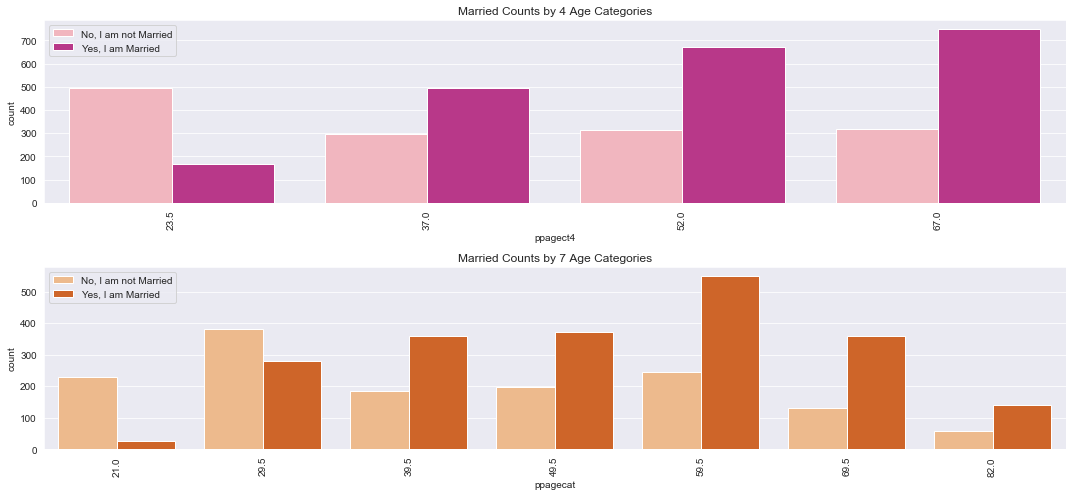

In [38]:
#Visualize age and marriage status
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
sns.countplot(couples.ppagect4, hue=couples.S1, palette='RdPu')
plt.xticks(rotation='vertical')
plt.title('Married Counts by 4 Age Categories')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
sns.countplot(couples.ppagecat, hue=couples.S1, palette='Oranges')
plt.xticks(rotation='vertical')
plt.title('Married Counts by 7 Age Categories')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The top chart conveys how the majority of respondents in their 30s or older are married, which is broken down further in the bottom chart into 7 categories. Virtually no one is married before 24, but as ages increase, the ratio of married to unmarried people increases until it is more than 2:1 by ages 55-64.

In [39]:
#Rank features by largest differences
sig_diffs=np.abs((couples.groupby('S1').mean().iloc[0]/couples.groupby('S1').mean().iloc[1])-1).sort_values(ascending=False)
sig_diffs

w6_q17                          0.579475
relate_duration_at_w6_years     0.519377
DOV_Branch                      0.379649
PPT612                          0.372932
ppincimp                        0.336095
time_from_rel_to_cohab          0.269772
PPT1317                         0.216901
ppage                           0.186138
age_when_met                    0.171990
w6_q9                           0.167466
Q9                              0.154667
pphhsize                        0.150045
w6_q24_length                   0.148601
hcm2017_q24_length              0.148513
PPT18OV                         0.115728
hcm2017q24_summary_all_codes    0.112294
female                          0.094831
Q16                             0.085008
weight1a_freqwt                 0.082076
weight1a                        0.082075
weight1_freqwt                  0.069412
weight1                         0.069412
time_from_met_to_rel            0.057214
duration                        0.052591
partner_yrsed   

Text(0.5, 1.0, 'Ratio of Married vs. Unmarried means per variable')

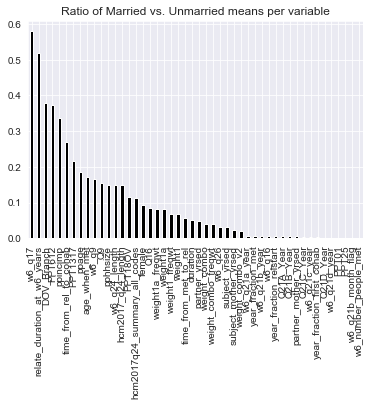

In [40]:
#Plot differences
sig_diffs.plot(kind='bar', color='k')
plt.title('Ratio of Married vs. Unmarried means per variable')

Here, the bar heights represent the sorted differences between means of married and unmarried groups. The leftmost features display, in variable-specific units, the largest differences between groups. These variables should have a strong impact on the models. The first variable indicates unmarried individuals meet, on average, 4 times as many partners for dating, romance, or sex than married individuals. 

__Top 3__

w6_number_people_met: How many people have you met in the last year for dating/romance/sex, not including partner?

relate_duration_at_w6_years: Years since meeting partner

PPT01: Number children aged 0 to 1

In [41]:
#Logistic Regression Model
#Drop all columns containing target information leakage
X=couples.drop(['partnership_status', 'ppmarit', 'S1', 'S2', 'w6_married', 'w6_q17', 'Q17A', 'Q21D_Year', 'w6_q21d_year', 'Q21D_Month', 'w6_q21d_month'], 1)
y=np.ravel(pd.get_dummies(couples['S1'], drop_first=True))
X=pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1)
lrm=LogisticRegression(solver='liblinear')
lrm.fit(X_train, y_train)
print(lrm.score(X_train, y_train))

0.8094333649889205


In [42]:
#Find optimal n_features to use for RFE via Recursive Feature Elimination Cross-Validation
selector= RFECV(lrm, step=2, n_jobs=-1, cv=5)
selector.fit(X_train, y_train)
print(selector.n_features_)

455


In [43]:
#Run model using optimal n_features
from sklearn.feature_selection import RFE
selector=RFE(lrm, n_features_to_select=selector.n_features_)
selector.fit(X_train, y_train)
selector.score(X_train, y_train)

0.9249762583095916

In [44]:
#Trim X 
X_train=X_train[X_train.columns[selector.support_]]
X_test=X_test[X_test.columns[selector.support_]]

In [45]:
#Tune LRM model
params_1= {'penalty': ['l1', 'l2'], 'C': [10.0**p for p in range(5)]}
lrmsearch1=GridSearchCV(LogisticRegression(solver='liblinear'),
                      param_grid=params_1, cv=5, n_jobs=-1, verbose=True)
lrmsearch1.fit(X_train, y_train)
print(lrmsearch1.best_params_, lrmsearch1.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


{'C': 1.0, 'penalty': 'l1'} 0.8961696739474517


In [46]:
#Score tuned LRM model
lrm_tuned= LogisticRegression(solver='liblinear', penalty= 'l1', C=lrmsearch1.best_params_['C'])
lrm_tuned.fit(X_train, y_train)
print('Cross validation scores: {}'.format(cross_val_score(lrm_tuned, X_train, y_train, cv=3)))
print('Mean score: {}'.format(cross_val_score(lrm_tuned, X_train, y_train, cv=3).mean()))

Cross validation scores: [0.88330171 0.90503324 0.90019011]
Mean score: 0.8961750200716331


In [47]:
#Display classification results of Logistic Regression model
tn, fp, fn, tp= np.ravel(confusion_matrix(y_train, lrm_tuned.predict(X_train)))
print('Recall Score: {0:.3f}'.format(tp/(tp+fn)))
print('Precision Score: {0:.3f}'.format(tp/(tp+fp)))
print('F1 Score: {0:.3f}'.format(f1_score(y_train, lrm_tuned.predict(X_train))))

Recall Score: 0.961
Precision Score: 0.926
F1 Score: 0.943


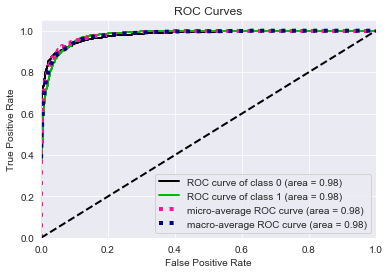

In [48]:
#Plot ROC curve 
y_probas = lrm_tuned.predict_proba(X_train)
skplt.metrics.plot_roc(y_train, y_probas)
plt.show()

In [49]:
# Initialize Random Forest Model
rfc= ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9031339031339032

In [50]:
cross_val_score(rfc, X_train, y_train, cv=3)

array([0.87760911, 0.89078822, 0.87737643])

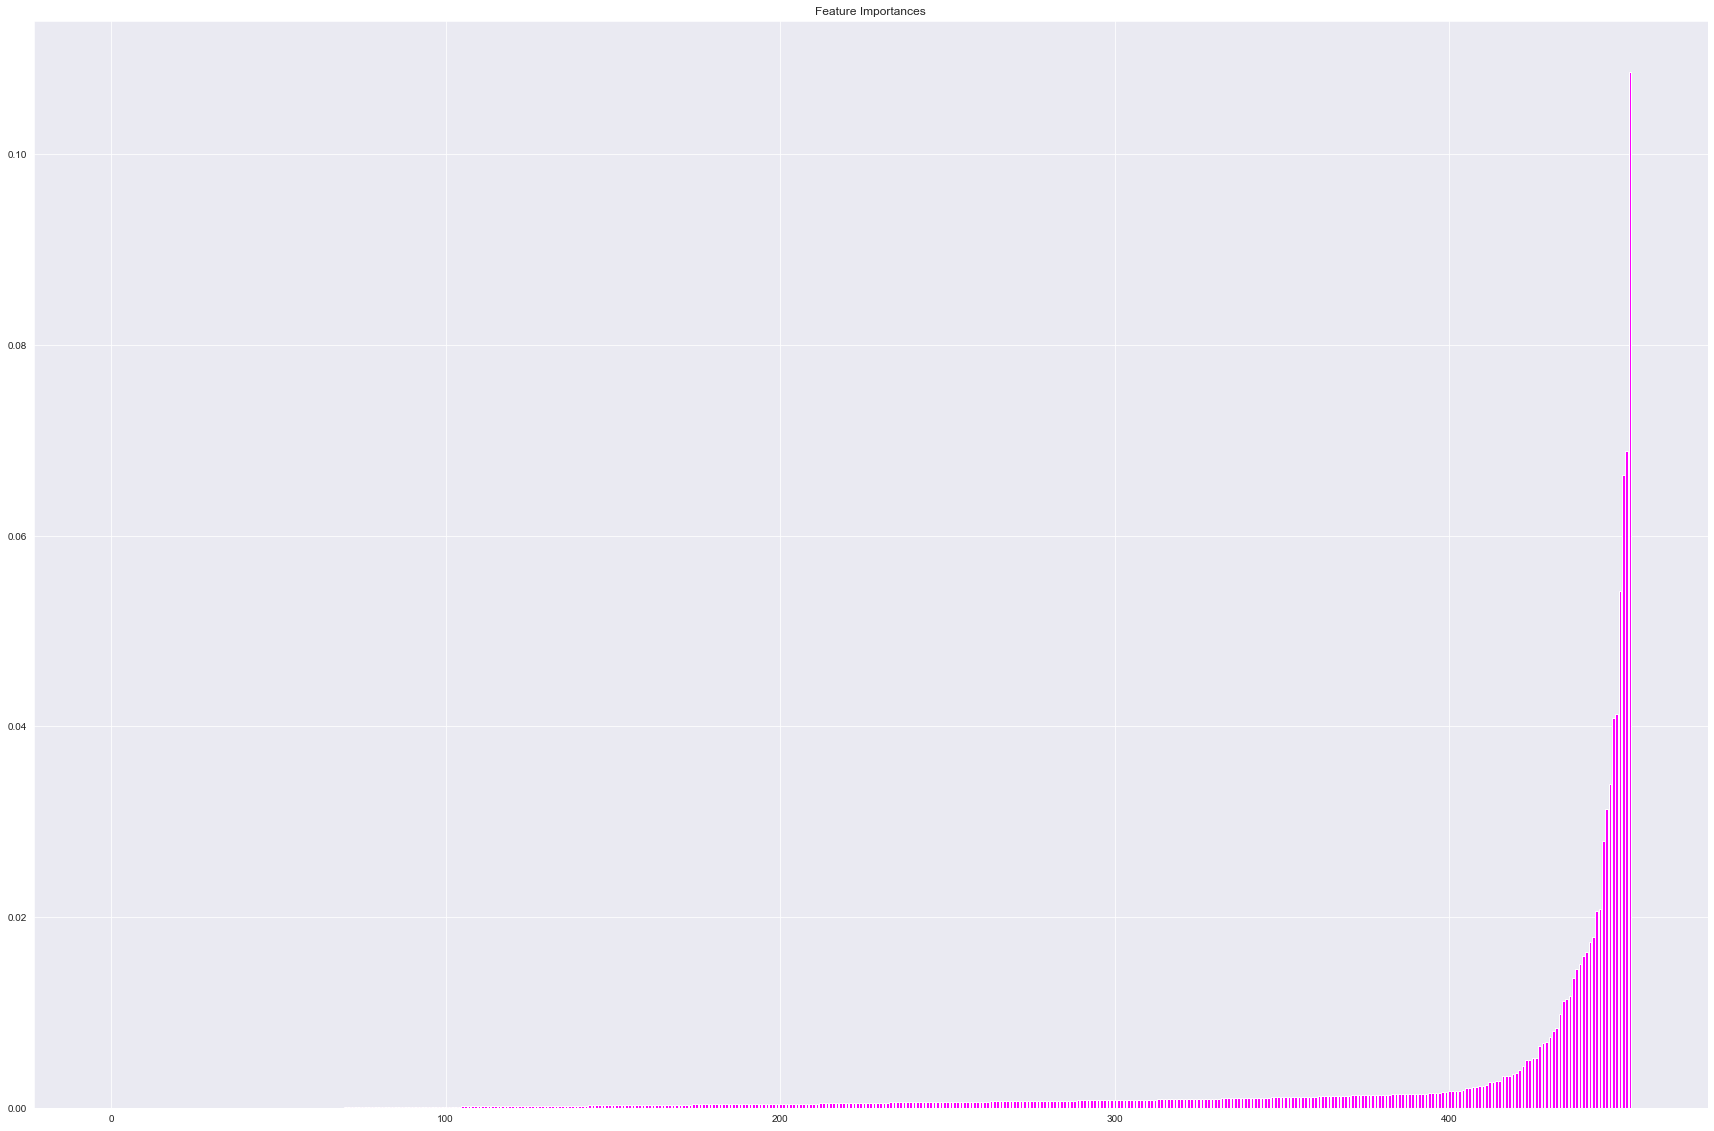

In [51]:
#Display features importances
feats= rfc.feature_importances_

sorted_index= np.argsort(feats)
pos=np.arange(sorted_index.shape[0])
plt.figure(figsize=(30, 20))
plt.bar(pos, feats[sorted_index], color='magenta')
plt.title('Feature Importances')
plt.show()

In [52]:
#Retain features using threshold 0.5% of decision trees
best_feats=[]
for feat in feats[sorted_index]:
    if feat> 0.005:
        best_feats.append(feat)
len(best_feats)

31

In [53]:
#New model using top features
X=X[X.columns[sorted_index][-(len(best_feats)):]]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

0.9946185501741057

In [54]:
#Find best preliminary n_estimators
#Using smaller featureset
params_1= {'n_estimators':range(30, 81, 10)}
gsearch1=GridSearchCV(ensemble.RandomForestClassifier(min_samples_split=30,min_samples_leaf=10,
                                                          max_depth=3,max_features='sqrt'),
                      param_grid=params_1, cv=5, n_jobs=-1)
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 60} 0.8797087685976575


In [55]:
#Find best depth & min_samples_split
params_2= {'max_depth':range(2, 8), 'min_samples_split':range(10, 51, 10)}
gsearch2=GridSearchCV(ensemble.RandomForestClassifier(n_estimators=gsearch1.best_params_['n_estimators'],
                                                      min_samples_leaf=10,max_features='sqrt'),
                      param_grid=params_2, cv=5, n_jobs=-1, verbose=True)
gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   16.4s finished


{'max_depth': 6, 'min_samples_split': 10} 0.8923710034821146


In [56]:
#Find best leaf and max_features
params_3= {'min_samples_leaf':range(1, 6), 'max_features':range(3, 10)}
gsearch3=GridSearchCV(ensemble.RandomForestClassifier(n_estimators=gsearch1.best_params_['n_estimators'],
                                                      max_depth=gsearch2.best_params_['max_depth'], 
                                                      min_samples_split=gsearch2.best_params_['min_samples_split']),
                      param_grid=params_3, cv=5, n_jobs=-1, verbose=True)
gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   22.0s finished


{'max_features': 7, 'min_samples_leaf': 1} 0.8911047799936689


In [57]:
rfc_tuned= ensemble.RandomForestClassifier(n_estimators=gsearch1.best_params_['n_estimators'], 
                                           max_depth=gsearch2.best_params_['max_depth'], 
                                           min_samples_split=gsearch2.best_params_['min_samples_split'], 
                                           max_features=gsearch3.best_params_['max_features'], 
                                           min_samples_leaf=gsearch3.best_params_['min_samples_leaf'], oob_score=True)
rfc_tuned.fit(X_train, y_train)
print('Tuned Model Training Set Score: {}'.format(rfc_tuned.score(X_train, y_train)))
print('OOB Score: {}'.format(rfc_tuned.oob_score_))

Tuned Model Training Set Score: 0.9085153529597974
OOB Score: 0.8879392212725546


In [58]:
#Score tuned RFC model
print('Cross_validation scores: {}'.format(cross_val_score(rfc_tuned, X_train, y_train, cv=3)))
print('Mean score: {}'.format(cross_val_score(rfc_tuned, X_train, y_train, cv=3).mean()))

Cross_validation scores: [0.90417457 0.88983856 0.88212928]
Mean score: 0.8923589146066297


In [59]:
#Display recall, precision, and F1 Score of RFC model
tn, fp, fn, tp= np.ravel(confusion_matrix(y_train, rfc_tuned.predict(X_train)))
print('Recall Score: {0:.3f}'.format(tp/(tp+fn)))
print('Precision Score: {0:.3f}'.format(tp/(tp+fp)))
print('F1 Score: {0:.3f}'.format(f1_score(y_train, rfc_tuned.predict(X_train))))

Recall Score: 0.951
Precision Score: 0.900
F1 Score: 0.925


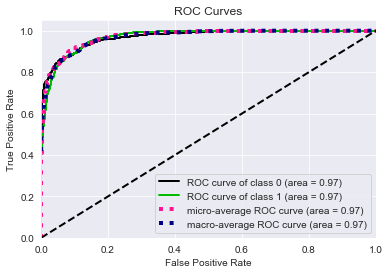

In [60]:
#Plot ROC curve for Random Forest
y_probas = rfc_tuned.predict_proba(X_train)
skplt.metrics.plot_roc(y_train, y_probas)
plt.show()

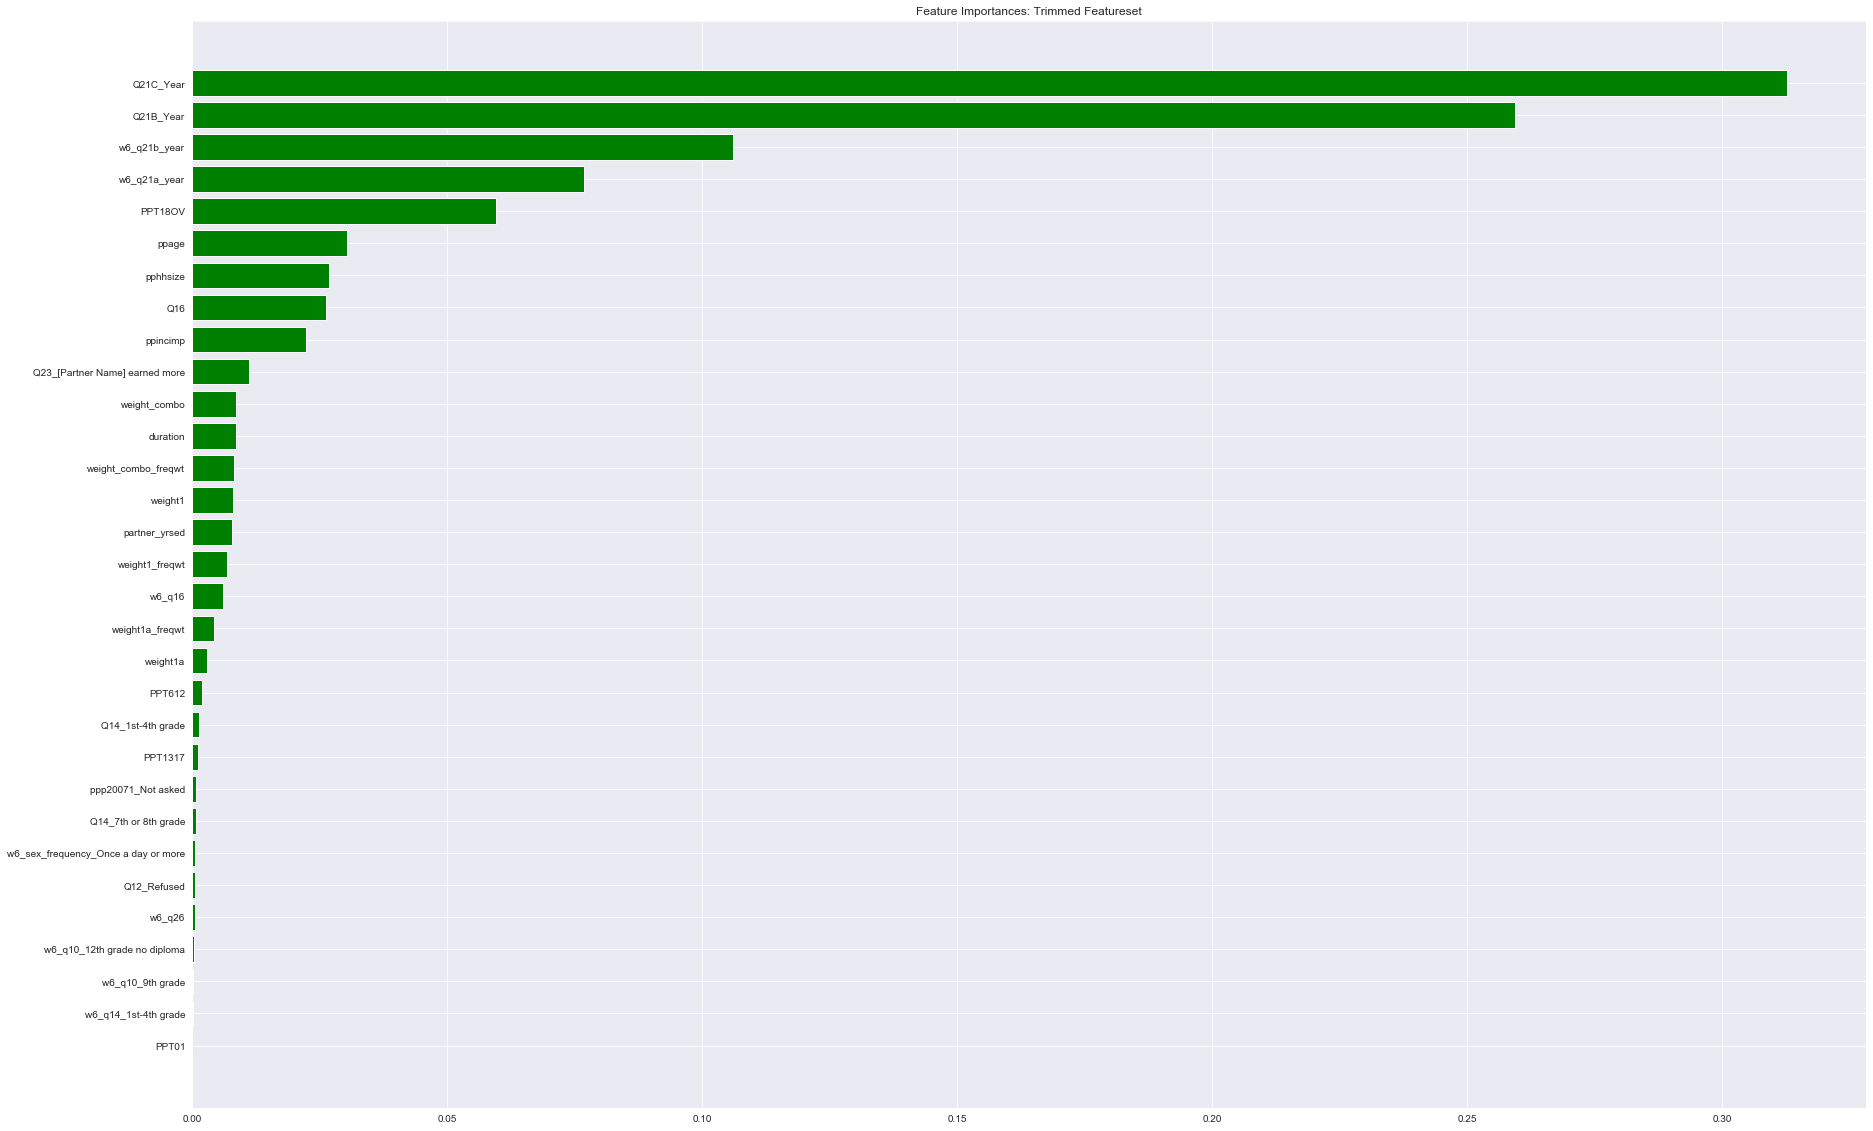

In [61]:
#Display features importances
feats= rfc_tuned.feature_importances_

sorted_index= np.argsort(feats)
pos=np.arange(sorted_index.shape[0])+0.5
plt.figure(figsize=(30, 20))
plt.barh(pos, feats[sorted_index], color='g')
plt.yticks(pos, X.columns[sorted_index])
plt.title('Feature Importances: Trimmed Featureset')
plt.show()

# Feature Importance: Top 5 Features Decoded

Q21A_Year: In what year did you first meet your partner?

Q21B_Year: In what year did your romantic relationship with your partner begin?

Q21C_Year: In what year did you first live together with your partner?

PPT18OV: Presence of household members 18+

w6_q21A_year: Recode of Q21Q_Year

In [62]:
#Initialize SVC model
svc=SVC(gamma='auto')
svc.fit(X_train, y_train)
svc.score(X_train, y_train)

0.9996834441278886

In [63]:
#Tune hyperparameters via GridSearch
Cs= [10.0**p for p in np.arange(-2, 5, 1)]
gammas= [10.0**p for p in np.arange(-5, 1)]
param_grid={'C':Cs, 'gamma':gammas}
gsv= GridSearchCV(svc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
gsv.fit(X_train, y_train)
print(gsv.best_params_, gsv.best_score_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  1.2min finished


{'C': 10000.0, 'gamma': 1e-05} 0.610636277302944


In [64]:
#Check accuracy of tuned SVC model
svc_tuned= SVC(C=gsv.best_params_['C'], gamma=gsv.best_params_['gamma'], probability=True)
svc_tuned.fit(X_train, y_train)
svc_tuned.score(X_train, y_train)

0.9990503323836657

In [65]:
#Cross Validation scores
print('Cross Validation Scores: {}'.format(cross_val_score(svc_tuned, X_train, y_train, cv=5)))
print('Mean score: {}'.format(cross_val_score(svc_tuned, X_train, y_train, cv=5).mean()))

Cross Validation Scores: [0.59968354 0.60126582 0.59810127 0.64556962 0.60855784]
Mean score: 0.6106356195711047


In [66]:
#Display recall, precision, and F1 Score of RFC model
tn, fp, fn, tp= np.ravel(confusion_matrix(y_train, svc_tuned.predict(X_train)))
print('Recall Score: {0:.3f}'.format(tp/(tp+fn)))
print('Precision Score: {0:.3f}'.format(tp/(tp+fp)))
print('F1 Score: {0:.3f}'.format(f1_score(y_train, svc_tuned.predict(X_train))))

Recall Score: 0.999
Precision Score: 0.999
F1 Score: 0.999


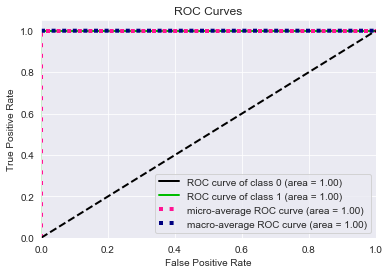

In [67]:
#Plot ROC curve for SVC
y_probas = svc_tuned.predict_proba(X_train)
skplt.metrics.plot_roc(y_train, y_probas)
plt.show()

In [68]:
#Divide train and test sets by target values for visualization 
X_train=X_train.reset_index(drop=True)
X_train_full=pd.concat([X_train, pd.Series(y_train).rename('y_train')], axis=1)
X_train_married= X_train_full[X_train_full.y_train==1].drop(columns='y_train')
X_train_unmarried= X_train_full[X_train_full.y_train==0].drop(columns='y_train')

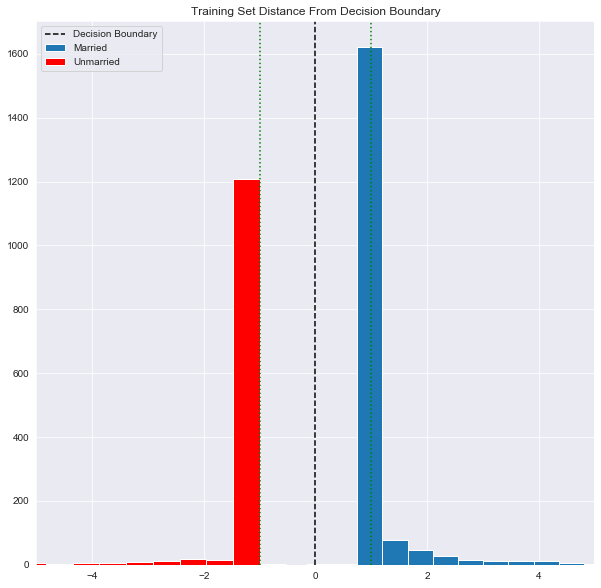

In [69]:
plt.figure(figsize=(10, 10))

plt.hist(svc_tuned.decision_function(X_train_married), label='Married', bins=25)
plt.hist(svc_tuned.decision_function(X_train_unmarried), color='red', label='Unmarried', bins=25)
plt.axvline(0, color='black', label='Decision Boundary', linestyle='--')
plt.axvline(-1, color='green', linestyle=':')
plt.axvline(1, color='green', linestyle=':')
plt.legend(loc='upper left')
plt.xlim(-5, 5)
plt.title('Training Set Distance From Decision Boundary')

plt.show()


The histograms depicted above illustrate the Support Vector Classifier's performance with respect to the decision boundary.  The vertical lines at -1 and 1 are the support vectors, and any points past the decision boundary at 0 were misclassified. Initially, results appear excellent, with an F1 score of .99 and only 2 points misclassified. However, the 5-fold cross validation scored 0.65, indicating the model is heavily overfit, and SVC should not be used on the test set. 

In [70]:
#Implement highest performing model on test set
#LRM scored highest on both F1 and 5-fold cross-validation
#Reset X to original RFE featureset
X=couples.drop(['partnership_status', 'ppmarit', 'S1', 'S2', 'w6_married', 'w6_q17', 'Q17A', 'Q21D_Year', 'w6_q21d_year', 'Q21D_Month', 'w6_q21d_month'], 1)
y=np.ravel(pd.get_dummies(couples['S1'], drop_first=True))
X=pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1)
X_train=X_train[X_train.columns[selector.support_]]
X_test=X_test[X_test.columns[selector.support_]]
lrm_tuned.fit(X_train, y_train)
lrm_tuned.score(X_test, y_test)

0.8888888888888888

Text(0, 0.5, 'Probability of Marriage')

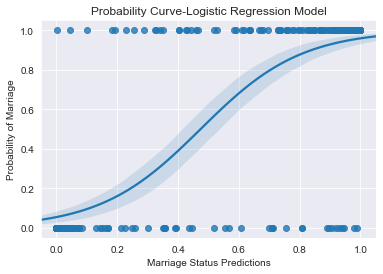

In [71]:
sns.regplot(lrm_tuned.predict_proba(X_test)[:, 1], y_test, logistic=True)
plt.title('Probability Curve-Logistic Regression Model')
plt.xlabel('Marriage Status Predictions')
plt.ylabel('Probability of Marriage')

In [72]:
top5_selector= RFE(lrm_tuned, n_features_to_select=5)
top5_selector.fit(X_test, y_test)
X_test.columns[top5_selector.support_]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Version

Index(['DOV_Branch', 'partyid7_Strong Republican',
       'w6_same_sex_couple_gender_hetero couple',
       'w6_q10_12th grade no diploma', 'w6_q19_Yes'],
      dtype='object')

# Conclusions 
__The top five most important features from the Linear Regression Model:__

DOV_Branch- Data only variable

partyid7_Strong Republican- Political Affiliation dummy

w6_same_sex_couple_gender_hetero couple- Which sexual orientation do you identify with most?

w6_q19_Yes- Are you currently living with your partner?

w6_q10_12th grade no diploma- Partner's Education level


__The five most important features from the tuned Random Forest model:__

Q21A_Year: In what year did you first meet your partner?

Q21B_Year: In what year did your romantic relationship with your partner begin?

Q21C_Year: In what year did you first live together with your partner?

PPT18OV: Presence of household members 18+

w6_q21A_year: Recode of Q21Q_Year

*_Feature importance data not collected from SVC as model necessitates transformation in higher dimension space*._

Based on the top 5 features selected from the RFC and LR models, the questions containing the most explanatory power were regarding when the couples moved in together and when they first met. Other honorable mentions include one-hot encoded variables of partner's educational level and a political category, but with less than 20 observations each, these were not statistically significant differences. In summary, length of relationship and living together with a partner are the most correlated variables with marriage status. 

# Limitations

## LGBTQ Subsample
The survey sampled 3510 participants, drawing upon 400 individuals identified as LGBTQ, a large oversampling (11.3%) as compared to the average US population(4.5%). The ratio of married to unmarried LGBT individuals in the survey is far different than general population, and may skew the explanatory power of the questions answered.


Source: https://williamsinstitute.law.ucla.edu/visualization/lgbt-stats/?topic=LGBT#density

## Survey Methods

As the survey results were self reported, some inaccuracies may be created from respondents omitting potentially embarrassing/sensitive personal information (e.g. Sex frequency and income information). Those who are less willing to share this information via survey collection agencies may exhibit different habits and behavioral patterns regarding partnerships than survey respondents. Additionally, as this was a one-time survey, respondents' relationship status may change after survey results were collected, which may provide more information regarding which features have the highest correlation with _lasting_ partnerships. 



# Further research

A follow up survey of the same group may yield critical insights into whether the top features selected here may predict future relationship status. Collecting more information about divorce rates and more data regarding each partner's satisfaction within the relationship may help determine the root causes of successful and unsuccessful marriages. As laws and public sentiment regarding gay marriage shift, will our sample exhibit similar shifts in relationship status distribution? Although the study briefly covered questions about online dating apps, a deeper foray into the subject may reveal further insights about societal dating trends in the modern age. 